In [2]:
%matplotlib inline
import csv
import numpy as np
import pickle
import sklearn
from sklearn import preprocessing,cross_validation,tree,metrics,decomposition,linear_model,pipeline,svm,grid_search,learning_curve
import matplotlib.pyplot as plt
from sklearn_pandas import DataFrameMapper, cross_val_score
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from scipy.interpolate import spline

# Load the dataset from dataframe
df = pickle.load(open("data.p", "rb"))

# Selected index number of gid, which has pickup number > 100 per hour per squared mile
index = [26,27,37,52,53,54,59,71,72,88,89,90,103,114,115,118,128,129,135,136,153,154,181,182,183,184]


# For each location, we tried different regressors and return the score of each regressors and mean-squared-error
# at this location
# Input: list of indexes of locations and list of regressors,fraction of split
# Output: Matrix of regressors, R^2 scores, Mean-squared-errors
def get_score(index,regressor,fraction):
    model = [] # Store all regressors
    score = np.zeros(len(index)) # Store all scores
    mse = np.zeros(len(index)) # Store all Mean-squared-errors
    for i in range(len(index)):
        df_1 = df[df['pickup_gid']==index[i]] # Get the trips of this location
        df_f = df_1[['pickup_dow','pickup_hour','temperature','precipitation','holiday','count_1']]
        response = df_1['count'].values # Get the response
        mapper = DataFrameMapper([('pickup_dow',preprocessing.LabelBinarizer()),
                                  ('pickup_hour',preprocessing.LabelBinarizer()),
                                  ('temperature',None),
                                  ('precipitation',None),
                                  ('holiday',preprocessing.LabelBinarizer()),
                                  ('count_1',None)])
        train = mapper.fit_transform(df_f.copy()) # Transform the train feature matiex
        X_train, X_test, y_train, y_test = cross_validation.train_test_split(train,response,test_size = fraction)
        re = regressor.fit(X_train,y_train)
        sc = regressor.score(X_test,y_test)
        y_pred = re.predict(X_test)
        score[i] = sc # R^2 score
        mse[i] = metrics.mean_squared_error(y_test,y_pred) # Mean squared error
        model.append(re)
    return model, score, mse

# Linear regression - Stochastic Gradient Descent
def sgd_regressor():
    sgd_params = {'penalty':['l1','l2'],'alpha':np.linspace(0.00001,0.01,10),'learning_rate':['invscaling','constant']
                  ,'power_t':[0.1,0.4],'eta0':[0.01,0.2,0.5]}
    grid_sgd = grid_search.GridSearchCV(linear_model.SGDRegressor(),sgd_params)
    return grid_sgd
    
# Linear regression
def linear_regressor():
    linear_regression = linear_model.LinearRegression()
    return linear_regression

# LASSO regression
def lasso_regressor():
    lasso_params = {'alpha':[0.01,0.1,0.2,0.3,0.5,1.0,2.0,5.0,10.0]}
    grid_lasso = grid_search.GridSearchCV(linear_model.Lasso(),lasso_params)
    return grid_lasso
    
# SVM regressor
def svr():
    svm_params = {'C':[1.0,10.0,100.0],'epsilon':[0.01,0.1,1.0],'kernel':['linear','poly','rbf','sigmoid'],
                  'degree':[2,3,5],'gamma':[0.001,0.01,0.1],'coef0':[0.0,1.0]}
    grid_svm = grid_search.GridSearchCV(svm.SVR(),svm_params)
    return svm.SVR(C=1000)

# Decision tree regressor
def dtree():
    tree_params = {'max_depth':[50,100],'min_samples_leaf':[2,3,5,10]}
    grid_tree = grid_search.GridSearchCV(sklearn.tree.DecisionTreeRegressor(),tree_params)
    return grid_tree

# Baysian Ridge Regressor
def bayseian():
    bayseian_params = {'n_iter':[300,500],'alpha_1':[1e-5,1e-6],'alpha_2':[1e-5,1e-6],'lambda_1':[1e-5,1e-6],
                      'lambda_2':[1e-5,1e-6]}
    grid_bay = grid_search.GridSearchCV(linear_model.BayesianRidge(),bayseian_params)
    return grid_bay
    
# Logistic Regressor
def logistic():
    log_params = {'penalty':['l1','l2'],'C':[1.0,10.0,100.0]}
    grid_log = grid_search.GridSearchCV(linear_model.LogisticRegression(),log_params)
    return grid_log

# Plot the performance of regressors
# Input: key = 1 is the R^2 score, key = 2 is the MSE
def plot(key):
    list1 = np.argsort(result_tree[key])
    x_new = []
    new_linear_1 = []
    new_linear_2 = []
    new_lasso_1 = []    
    new_lasso_2 = []
    new_tree_1 = []
    new_tree_2 = []
    new_svr_1 = []
    new_svr_2 = []
    new_bayseian_1 = []
    new_bayseian_2 = []
    for i in range(len(list1)):
        x_new.append(index[list1[i]])
        new_linear_1.append(result_linear[1][list1[i]])
        new_linear_2.append(result_linear[2][list1[i]])
        new_lasso_1.append(result_lasso[1][list1[i]])
        new_lasso_2.append(result_lasso[2][list1[i]])
        new_tree_2.append(result_tree[2][list1[i]])
        new_tree_1.append(result_tree[1][list1[i]])
        new_svr_1.append(result_svr[1][list1[i]])
        new_svr_2.append(result_svr[2][list1[i]])
        new_bayseian_1.append(result_bayseian[1][list1[i]])
        new_bayseian_2.append(result_bayseian[2][list1[i]])
    x_new = np.array(x_new)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if key == 1:
        ax.plot(new_linear_1, label='Linear')
        ax.plot(new_lasso_1, label='Lasso')
        ax.plot(new_tree_1, label='Decision Tree')
        ax.plot(new_svr_1,label='SVR')
        ax.plot(new_bayseian_1,label='Bayseian Ridge Regression')
        ax.set_xticklabels(x_new)
        ax.set_ylabel('R^2 Score')
        ax.set_title('Comparison of R^2 score of regressors')
        ax.set_xlabel('gid')
        ax.legend(loc='lower right')
    else:
        ax.plot(np.sqrt(new_linear_2), label='Linear')
        ax.plot(np.sqrt(new_lasso_2), label='Lasso')
        ax.plot(np.sqrt(new_tree_2), label='Decision Tree')
        ax.plot(np.sqrt(new_svr_2),label='SVR')
        ax.plot(np.sqrt(new_bayseian_2),label='Bayseian Ridge Regression')
        ax.set_xticklabels(x_new)
        ax.set_ylabel('Mean squared error')
        ax.set_xlabel('gid')
        ax.legend(loc='upper left')
        ax.set_title('Comparison of root mean squared error of regressors')
    plt.show
    
# print the learning curve of selected regressor and gid
def lc(regressor,ind):
    df_1 = df[df['pickup_gid']==ind] # Get the trips of this location
    X = df_1[['pickup_dow','pickup_hour','temperature','precipitation','holiday','count_1']]
    response = df_1['count'].values
    train_sizes, train_scores, test_scores = learning_curve.learning_curve(regressor, X, y=response)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes,train_scores_mean,label = 'train_score')
    plt.plot(train_sizes,test_scores_mean,label = 'test_score')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Learning Curve for Decision Tree Regreesion model at gid 27')
    plt.xlabel('train size')
    plt.ylabel('R^2 Score')
    plt.ylim(0.8,1)
    plt.show()
    
# Print the histogram of the given regressor and index number
def histogram(regressor,index):
    gid = df[df['pickup_gid']==index].iloc[:167]
    df_f = gid[['pickup_dow','pickup_hour','temperature','precipitation','holiday','count_1']]
    y_true = gid['count'].values # Get the response
    mapper = DataFrameMapper([('pickup_dow',preprocessing.LabelBinarizer()),
                              ('pickup_hour',preprocessing.LabelBinarizer()),
                              ('temperature',None),
                              ('precipitation',None),
                              ('holiday',preprocessing.LabelBinarizer()),
                              ('count_1',None)])
    X_train = mapper.fit_transform(df_f.copy())
    y_pred = regressor.predict(X_train)
    ax = plt.subplot(111)
    w = 1
    x = np.linspace(1,167,167)
    ax.bar(x, y_true,width=w,color='b',align='center',label='y_true')
    ax.bar(x, -y_pred,width=w,color='g',align='center',label='y_pred')
    ax.autoscale(tight=True)
    plt.xlabel('Hour from 0 to 72')
    plt.ylabel('Total number of trip')
    plt.title('y_pred vs y_true at gid 27, using Decision Tree Regressor')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
# Get the score of different regressors
result_linear = get_score(index,linear_regressor(),0.2)
#result_sgd = get_score(index,sgd_regressor(),0.2)
result_lasso = get_score(index,lasso_regressor(),0.2)
result_svr = get_score(index,svr(),0.2)
result_tree = get_score(index,dtree(),0.2)
result_bayseian = get_score(index,bayseian(),0.2)
#result_logistic = get_score(index,logistic(),0.2)

# Plot the R^2 of different regressors
#plot(1)

# Plot the MSE of regressors
plot(2)

# Plot the learning curve
#lc(result_tree[0][1].best_estimator_,27)

# Plot Histogram
histogram(result_tree[0][1].best_estimator_.)

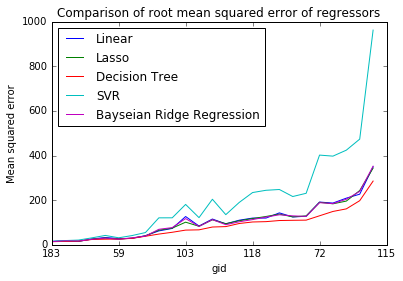